In [1]:
import numpy as np
import pandas as pd
import os 

In [2]:
categories = ['Airplane', 'Alarm', 'Beep/Bleep', 'Bell', 'Bicycle', 'Bird Chirp', 'Bus', 'Car', 'Cat Meow',
        'Chainsaw', 'Clapping', 'Cough', 'Cow Moo', 'Cowbell', 'Crying', 'Dog Bark', 'Doorbell', 'Drip',
        'Drums', 'Fire', 'Footsteps', 'Guitar', 'Hammer', 'Helicopter', 'Hiccup', 'Horn Honk', 'Horse Neigh',
        'Insect Buzz', 'Jackhammer', 'Laughter', 'Lawn Mower', 'Motorcycle', 'Piano', 'Pig Oink', 'Power Drill',
        'Power Saw', 'Rain', 'Rooster Crow', 'Saxophone', 'Sewing Machine', 'Sheep/Goat Bleat', 'Ship/Boat',
        'Shout', 'Singing', 'Siren', 'Sneeze', 'Snoring', 'Speech', 'Stream/River', 'Thunder', 'Train', 'Truck',
        'Trumpet', 'Vacuum Cleaner', 'Violin', 'Washing Machine', 'Waves', 'Wind']

In [3]:
ann_df = pd.read_csv(
    'annotations.csv'
)
meta_df = pd.read_csv(
    'metadata.csv'
)
ann_df.shape


(27552, 9)

In [4]:
train_filename = meta_df.sample(len(meta_df),random_state=42)['filename'].unique()[:int(len(meta_df)*0.7)]
validation_filename = meta_df.sample(len(meta_df),random_state=42)['filename'].unique()[int(len(meta_df)*0.7):int(len(meta_df)*0.9)]
test_filename = meta_df.sample(len(meta_df),random_state=42)['filename'].unique()[int(len(meta_df)*0.9):len(meta_df)]




In [5]:
def aggregate_labels(file_labels):
    __y = []
    for frame_labels in file_labels:
        if(sum(frame_labels) == 0):
            __y.append([0])
        elif(np.count_nonzero(frame_labels) == len(frame_labels)):
             __y.append([1])
        else: #The annotators don't agree on the label
            __y.append([np.random.choice(frame_labels)])
    return __y

In [6]:
features_dir = "audio_features"
labels_dir = "labels"

import itertools
def read_files(file_names):
    X_train = []
    Y_train = {c: [] for c in categories}  # Initialize label dictionary
    
    for f in file_names:
        # Load melspectrogram and MFCC features
        features_mel = np.load(os.path.join(features_dir, f.split('.')[0] + '.npz'))["melspectrogram"]
        features_mfcc = np.load(os.path.join(features_dir, f.split('.')[0] + '.npz'))["mfcc"]
        
        
        # Pad or truncate all features to have the same number of timesteps
        min_length = min(features_mel.shape[0], features_mfcc.shape[0])
        features_mel = features_mel[:min_length]
        features_mfcc = features_mfcc[:min_length]
        
        # Concatenate features along feature axis (axis=1)
        features = np.concatenate([features_mel, features_mfcc], axis=1)
        X_train.append(features)
        
        # Load and process labels
        y = np.load(os.path.join(labels_dir, f.split('.')[0] + '_labels.npz'))
        for c in categories:
            _y = aggregate_labels(y[c])
            Y_train[c].extend(list(itertools.chain.from_iterable(_y))[:min_length])  # Match length
    
    X_train = np.concatenate(X_train)
    return X_train, Y_train

In [7]:
from sklearn.preprocessing import StandardScaler
def preprocessing(array):
    s=StandardScaler()
    scaled_array = s.fit_transform(array)
    scalar =s.fit(array)
    return scaled_array,scalar.mean_,scalar.scale_

In [8]:
train_x,train_y = read_files(train_filename)
val_x, val_y = read_files(validation_filename)
test_x, test_y = read_files(test_filename)

In [9]:
scaled_train_x,mu,std =preprocessing(train_x)
scaled_validation_x = (val_x - mu)/std
scaled_test_x = (test_x - mu)/std

In [10]:
train_y = np.array([train_y[cls] for cls in categories]).T
val_y = np.array([val_y[cls] for cls in categories]).T
test_y = np.array([test_y[cls] for cls in categories]).T
train_y.shape

(1078243, 58)

In [49]:
import torch
import torch.nn as nn

class LSTMAED(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, num_layers=2, dropout=0.3,bidirectional=False):
        super(LSTMAED, self).__init__()
        self.bilstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout
        )
        if bidirectional is True:
            linear= nn.Linear(hidden_dim * 2, num_classes)
        else:
            linear= nn.Linear(hidden_dim, num_classes)
        self.classifier = nn.Sequential( linear)

    def forward(self, x):
        lstm_out, _ = self.bilstm(x)  
        out = self.classifier(lstm_out)  
        return out

In [50]:
lstm=LSTMAED(96,128,58)
BiLSTM=LSTMAED(96,128,58,bidirectional=True)

In [53]:
def train_model(model):
    import torch
    import torch.nn as nn
    from torch.utils.data import DataLoader, TensorDataset
    from torch.nn.functional import sigmoid

    device = "cuda"
    model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    training_loss = []
    validation_loss = []

    # Datasets
    batch_size = 32
    scaled_train_x_tensor = torch.tensor(scaled_train_x, dtype=torch.float32)
    train_y_tensor = torch.tensor(train_y, dtype=torch.float32)
    scaled_validation_x_tensor = torch.tensor(scaled_validation_x, dtype=torch.float32)
    val_y_tensor = torch.tensor(val_y, dtype=torch.float32)

    train_dataset = TensorDataset(scaled_train_x_tensor, train_y_tensor)
    val_dataset = TensorDataset(scaled_validation_x_tensor, val_y_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    num_epochs = 6

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for x_batch, y_batch in train_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            output = model(x_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            preds = (sigmoid(output) > 0.5).int()
            targets = y_batch.int()
            train_correct += (preds == targets).sum().item()
            train_total += targets.numel()

        train_accuracy = train_correct / train_total
        avg_train_loss = train_loss / len(train_loader)
        training_loss.append(avg_train_loss)

        # ----------- Validation and Metrics -----------
        model.eval()
        val_loss = 0.0
        all_preds = []
        all_targets = []

        with torch.no_grad():
            for x_val, y_val in val_loader:
                x_val = x_val.to(device)
                y_val = y_val.to(device)

                val_output = model(x_val)
                val_loss += criterion(val_output, y_val).item()

                probs = sigmoid(val_output)
                preds = (probs > 0.5).int()
                targets = y_val.int()

                all_preds.append(preds)
                all_targets.append(targets)

        avg_val_loss = val_loss / len(val_loader)
        validation_loss.append(avg_val_loss)

        # Stack predictions
        all_preds = torch.cat(all_preds, dim=0)
        all_targets = torch.cat(all_targets, dim=0)

        # Compute metrics
        TP = (all_preds & all_targets).sum(dim=0).float()
        FP = ((all_preds == 1) & (all_targets == 0)).sum(dim=0).float()
        FN = ((all_preds == 0) & (all_targets == 1)).sum(dim=0).float()
        TN = ((all_preds == 0) & (all_targets == 0)).sum(dim=0).float()

        precision = TP / (TP + FP + 1e-8)
        recall = TP / (TP + FN + 1e-8)
        f1 = (2 * precision * recall) / (precision + recall + 1e-8)
        tnr = TN / (TN + FP + 1e-8)
        balanced_acc = (recall + tnr) / 2

        avg_precision = precision.mean().item()
        avg_recall = recall.mean().item()
        avg_f1 = f1.mean().item()
        avg_bal_acc = balanced_acc.mean().item()
        val_accuracy = (all_preds == all_targets).float().mean().item()

        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print(f"Train Loss:                  {avg_train_loss:.4f}")
        print(f"Train Accuracy:              {train_accuracy:.4f}")
        print(f"Val Loss:                    {avg_val_loss:.4f}")
        print(f"Validation Accuracy:         {val_accuracy:.4f}")
        print(f"Precision:                   {avg_precision:.4f}")
        print(f"Recall:                      {avg_recall:.4f}")
        print(f"F1 Score:                    {avg_f1:.4f}")
        print(f"Average Balanced Accuracy:   {avg_bal_acc:.4f}")

    # Save model
    torch.save(model.state_dict(), 'spectrogram_transformer_weights.pth')
    torch.save(model, 'spectrogram_transformer_full_model.pth')

    return training_loss, validation_loss, {
        "precision": avg_precision,
        "recall": avg_recall,
        "f1": avg_f1,
        "balanced_accuracy": avg_bal_acc,
        "val_accuracy": val_accuracy
    }

In [73]:
def test_model(model):
    import torch
    import torch.nn as nn
    from torch.utils.data import DataLoader, TensorDataset
    from torch.nn.functional import sigmoid

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    model.eval()  # Set model to evaluation mode
    
    criterion = nn.BCEWithLogitsLoss()

    # Datasets
    batch_size = 32
    scaled_test_x_tensor = torch.tensor(scaled_test_x, dtype=torch.float32).to(device)
    test_y_tensor = torch.tensor(test_y, dtype=torch.float32).to(device)

    test_dataset = TensorDataset(scaled_test_x_tensor, test_y_tensor)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    test_loss = 0.0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for x_test, y_test in test_loader:
            x_test, y_test = x_test.to(device), y_test.to(device)
            output = model(x_test)
            test_loss += criterion(output, y_test).item()

            probs = sigmoid(output)
            preds = (probs > 0.5).int()
            all_preds.append(preds)
            all_targets.append(y_test.int())

    # Calculate average test loss
    avg_test_loss = test_loss / len(test_loader)

    # Stack predictions for metric calculations
    all_preds = torch.cat(all_preds, dim=0)
    all_targets = torch.cat(all_targets, dim=0)

    # Calculate metrics
    TP = (all_preds & all_targets).sum(dim=0).float()
    FP = ((all_preds == 1) & (all_targets == 0)).sum(dim=0).float()
    FN = ((all_preds == 0) & (all_targets == 1)).sum(dim=0).float()
    TN = ((all_preds == 0) & (all_targets == 0)).sum(dim=0).float()

    precision = TP / (TP + FP + 1e-8)
    recall = TP / (TP + FN + 1e-8)
    f1 = (2 * precision * recall) / (precision + recall + 1e-8)
    tnr = TN / (TN + FP + 1e-8)
    balanced_acc = (recall + tnr) / 2

    avg_precision = precision.mean().item()
    avg_recall = recall.mean().item()
    avg_f1 = f1.mean().item()
    avg_bal_acc = balanced_acc.mean().item()
    test_accuracy = (all_preds == all_targets).float().mean().item()

    # Print results
    print("\nTest Results")
    print(f"Test Loss:                 {avg_test_loss:.4f}")
    print(f"Test Accuracy:             {test_accuracy:.4f}")
    print(f"Precision:                 {avg_precision:.4f}")
    print(f"Recall:                    {avg_recall:.4f}")
    print(f"F1 Score:                  {avg_f1:.4f}")
    print(f"Average Balanced Accuracy: {avg_bal_acc:.4f}")

    return {
        "test_loss": avg_test_loss,
        "test_accuracy": test_accuracy,
        "precision": avg_precision,
        "recall": avg_recall,
        "f1": avg_f1,
        "balanced_accuracy": avg_bal_acc
    }


In [55]:
tr_loss, val_loss, eval_dict =  train_model(lstm)

C:\Users\beiba\AppData\Local\Temp\ipykernel_16820\1951892798.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scaled_train_x_tensor = torch.tensor(scaled_train_x, dtype=torch.float32)
C:\Users\beiba\AppData\Local\Temp\ipykernel_16820\1951892798.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_y_tensor = torch.tensor(train_y, dtype=torch.float32)
C:\Users\beiba\AppData\Local\Temp\ipykernel_16820\1951892798.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_y_tensor = torch.tensor(val_y, dtype=torch.float32)



Epoch 1/6
Train Loss:                  0.0755
Train Accuracy:              0.9798
Val Loss:                    0.0764
Validation Accuracy:         0.9796
Precision:                   0.3334
Recall:                      0.0430
F1 Score:                    0.0664
Average Balanced Accuracy:   0.5211

Epoch 2/6
Train Loss:                  0.0704
Train Accuracy:              0.9803
Val Loss:                    0.0760
Validation Accuracy:         0.9796
Precision:                   0.4015
Recall:                      0.0580
F1 Score:                    0.0892
Average Balanced Accuracy:   0.5284

Epoch 3/6
Train Loss:                  0.0686
Train Accuracy:              0.9806
Val Loss:                    0.0763
Validation Accuracy:         0.9797
Precision:                   0.4024
Recall:                      0.0684
F1 Score:                    0.1046
Average Balanced Accuracy:   0.5335

Epoch 4/6
Train Loss:                  0.0675
Train Accuracy:              0.9807
Val Loss:           

In [70]:

tr_loss_bi, val_loss_bi, eval_dict_bi =  train_model(BiLSTM)

C:\Users\beiba\AppData\Local\Temp\ipykernel_16820\1951892798.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scaled_train_x_tensor = torch.tensor(scaled_train_x, dtype=torch.float32)
C:\Users\beiba\AppData\Local\Temp\ipykernel_16820\1951892798.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_y_tensor = torch.tensor(train_y, dtype=torch.float32)
C:\Users\beiba\AppData\Local\Temp\ipykernel_16820\1951892798.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_y_tensor = torch.tensor(val_y, dtype=torch.float32)



Epoch 1/6
Train Loss:                  0.0711
Train Accuracy:              0.9804
Val Loss:                    0.0763
Validation Accuracy:         0.9797
Precision:                   0.4401
Recall:                      0.0889
F1 Score:                    0.1321
Average Balanced Accuracy:   0.5436

Epoch 2/6
Train Loss:                  0.0622
Train Accuracy:              0.9816
Val Loss:                    0.0782
Validation Accuracy:         0.9794
Precision:                   0.4164
Recall:                      0.1073
F1 Score:                    0.1535
Average Balanced Accuracy:   0.5524

Epoch 3/6
Train Loss:                  0.0594
Train Accuracy:              0.9822
Val Loss:                    0.0793
Validation Accuracy:         0.9794
Precision:                   0.4301
Recall:                      0.1125
F1 Score:                    0.1641
Average Balanced Accuracy:   0.5549

Epoch 4/6
Train Loss:                  0.0578
Train Accuracy:              0.9826
Val Loss:           

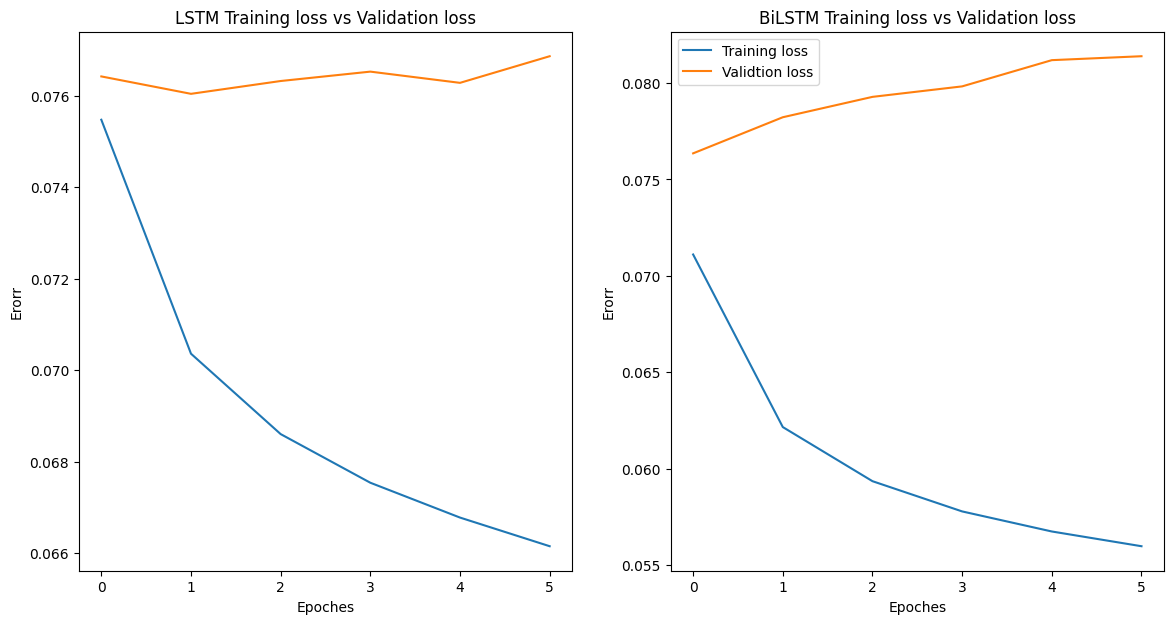

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns
fig,ax = plt.subplots(1,2,figsize=(14,7))
ax[0].plot(range(6),tr_loss,label="Training loss"),
ax[0].plot(range(6),val_loss,label = "Validtion loss")
ax[0].set_title("LSTM Training loss vs Validation loss")
ax[0].set_xlabel("Epoches")
ax[0].set_ylabel("Erorr")
ax[1].plot(range(6),tr_loss_bi,label="Training loss"),
ax[1].plot(range(6),val_loss_bi,label = "Validtion loss")
ax[1].set_title("BiLSTM Training loss vs Validation loss")
ax[1].set_xlabel("Epoches")
ax[1].set_ylabel("Erorr")
plt.legend()

In [74]:
test_model(lstm)


Test Results
Test Loss:                 0.0797
Test Accuracy:             0.9792
Precision:                 0.3636
Recall:                    0.0721
F1 Score:                  0.1038
Average Balanced Accuracy: 0.5352


{'test_loss': 0.07970643912616339,
 'test_accuracy': 0.9792429804801941,
 'precision': 0.3636426329612732,
 'recall': 0.07209545373916626,
 'f1': 0.10382057726383209,
 'balanced_accuracy': 0.5351833701133728}

In [75]:
test_model(BiLSTM)


Test Results
Test Loss:                 0.0854
Test Accuracy:             0.9787
Precision:                 0.3311
Recall:                    0.1067
F1 Score:                  0.1518
Average Balanced Accuracy: 0.5518


{'test_loss': 0.08538580974653322,
 'test_accuracy': 0.9786700010299683,
 'precision': 0.3311094641685486,
 'recall': 0.106710284948349,
 'f1': 0.15176373720169067,
 'balanced_accuracy': 0.5517522692680359}

In [72]:
torch.save(lstm.state_dict(), 'lstm_weights.pth')
torch.save(lstm, 'lstm_full_model.pth')